In [5]:
import utils
import torch
import math
import numpy as np 
from PIL import Image
import cv2
import os
from pathlib import *
import shutil
import pandas as PD
import matplotlib.pyplot as plt
%matplotlib inline
PD.options.display.expand_frame_repr = False

In [6]:
display = utils.notebook_init() 
print('cuda доступна', torch.cuda.is_available())
print('под каким номером куда:',torch.cuda.current_device())
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" #без этого ошибка будет

YOLOv5  v6.1-258-g1156a32 Python-3.8.13 torch-1.11.0 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)


Setup complete  (16 CPUs, 39.3 GB RAM, 213.1/953.9 GB disk)
cuda доступна True
под каким номером куда: 0


In [7]:
with open('Y:\sample_solution.csv', 'r', encoding='utf-8') as file:
    for line in file:
        l1 = line[-1]
        break
        print(line[-1])
with open('Y:\\test.csv', 'r', encoding='utf-8') as file:
    for line in file:
        l2 = line[-1]
        break
        print(line)
print(l1==l2) 

True


In [7]:
#Вот без этого ничего не работает.
#функция крутит картинку в зависимости от того, что нашла в характеристиках файла. 
def exif_transpose(img):
    if not img:
        return img

    exif_orientation_tag = 274

    # Check for EXIF data (only present on some files)
    if hasattr(img, "_getexif") and isinstance(img._getexif(), dict) and exif_orientation_tag in img._getexif():
        exif_data = img._getexif()
        orientation = exif_data[exif_orientation_tag]

        # Handle EXIF Orientation
        if orientation == 1:
            # Normal image - nothing to do!
            pass
        elif orientation == 2:
            # Mirrored left to right
            img = img.transpose(PIL.Image.FLIP_LEFT_RIGHT)
        elif orientation == 3:
            # Rotated 180 degrees
            img = img.rotate(180)
        elif orientation == 4:
            # Mirrored top to bottom
            img = img.rotate(180).transpose(PIL.Image.FLIP_LEFT_RIGHT)
        elif orientation == 5:
            # Mirrored along top-left diagonal
            img = img.rotate(-90, expand=True).transpose(PIL.Image.FLIP_LEFT_RIGHT)
        elif orientation == 6:
            # Rotated 90 degrees
            #print('повернули')
            img = img.rotate(-90, expand=True)
        elif orientation == 7:
            # Mirrored along top-right diagonal
            img = img.rotate(90, expand=True).transpose(PIL.Image.FLIP_LEFT_RIGHT)
        elif orientation == 8:
            # Rotated 270 degrees
            img = img.rotate(90, expand=True)

    return img

In [4]:
model = torch.hub.load('ultralytics/yolov5', 'custom',  path='runs\\train\\exp002\\weights\\best.pt') #работает, но загружает каждый раз

Using cache found in C:\Users\Алексей/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  v6.1-258-g1156a32 Python-3.8.13 torch-1.11.0 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)

Fusing layers... 
Model summary: 290 layers, 20856975 parameters, 0 gradients
Adding AutoShape... 


# получаем из картинки знак и все его параметры

In [9]:
def get_distance(p):
    if len(p) != 2: 
        return 0
    d = (p[0][0]-p[1][0])**2 + (p[0][1]-p[1][1])**2
    d = d**0.5
    return d
def res(file, show_pandas = 0):
    if '.heic' in file:
        
        #name_f =file[file.rfind('\\')+1:]
        #name_f = name_f.replace('.heic','.jpg')
        temp_file = 'Y:\\tmp.jpg'
        file = conv_heic_to_jpg(work_file,temp_file)
    
    im = Image.open(file)
    (width, height) = im.size
    
    results = model(file)
    pd = results.pandas().xyxy[0]
    
    pd_point = pd.loc[pd['name'] == 'point']            #таблица с точками
    pd = pd.loc[pd['name'] == 'znak']                   #таблица со знаками
    
    #все номера нам не надо. Нам надо только тот, что ближе к центру

    #ОБРАБАТЫВАЕМ ЗНАКИ
    if show_pandas == 1:
        print('Знаки\n',pd)
        print('Точки\n',pd_point)
    
    pd = pd.assign(to_centre_x = abs(width/2 - (pd.xmin + (pd.xmax-pd.xmin)/2)))     #считаем расстояние до центра
    pd = pd.assign(centre_x = pd.xmin + (pd.xmax-pd.xmin)/2)                         #считаем координаты центра 
    
    pd = pd.assign(width = pd.xmax - pd.xmin)                                        #ширина
    pd = pd.assign(height = pd.ymax - pd.ymin)                                       #высота
    pd = pd.assign(s2 = pd.width * pd.height)                                        #площадь
    
    pd = pd.sort_values(['to_centre_x'] )                                            #сортируем по близости к центру. Нам надо самый близкий номер
    
    
    d = dict()   #в этом словаре будут все результаты
    for index, row in pd.iterrows():
        d ['width']  = row['width']
        d ['height']  = row['height']
        d ['s2']  = row['s2']
        d ['xmin']  = row['xmin']
        d ['ymin']  = row['ymin']
        d ['xmax']  = row['xmax']
        d ['ymax']  = row['ymax']
        break
    #Сейчас в d - все характеристики знака. 
    
    
    #ОБРАБАТЫВАЕМ POINTS. Берем только те, что входят в область нашего знака. В идеале их должно быть две.
    pd_point = pd_point.assign(centre_x = pd_point.xmin + (pd_point.xmax-pd_point.xmin)/2)   #Yнам нужны будут только центры точек
    pd_point = pd_point.assign(centre_y = pd_point.ymin + (pd_point.ymax-pd_point.ymin)/2)   #Yнам нужны будут только центры точек
    
    
    pd_point = pd_point.sort_values(['centre_x'] )
    if show_pandas == 1:
        print('все найденные точки\n',pd_point)
    points_in_znak =[]
    for index, row in pd_point.iterrows():
        if (d['xmin'] < row['centre_x'] < d['xmax']) and (d['ymin'] < row['centre_y'] < d['ymax']):
            points_in_znak.append([row['centre_x'],row['centre_y']])
    
    if show_pandas == 1:
        print('координаты точек в знаке', points_in_znak)
    
    d['main_line'] = get_distance(points_in_znak)
    
    d['im_width'] = width
    d['im_height'] = height
    
    
    return d    
        
             

In [18]:
#проверка. работаем с одним файлом
znak = res('..\\avto\\start_dataset\\train\\img_2857.jpg',1)
print(znak)

Знаки
          xmin         ymin         xmax         ymax  confidence  class  name
0  1535.85144  1863.303589  2324.896729  2067.819824    0.970461      1  znak
Точки
           xmin         ymin         xmax         ymax  confidence  class   name
1  1557.435913  1944.574219  1576.093262  1963.043945    0.745901      0  point
2  2290.218994  1976.793701  2308.145020  1993.443848    0.635500      0  point
все найденные точки
           xmin         ymin         xmax         ymax  confidence  class   name     centre_x     centre_y
1  1557.435913  1944.574219  1576.093262  1963.043945    0.745901      0  point  1566.764587  1953.809082
2  2290.218994  1976.793701  2308.145020  1993.443848    0.635500      0  point  2299.182007  1985.118774
координаты точек в знаке [[1566.7645874023438, 1953.80908203125], [2299.1820068359375, 1985.1187744140625]]
{'width': 789.0452880859375, 'height': 204.5162353515625, 's2': 161372.57184122503, 'xmin': 1535.8514404296875, 'ymin': 1863.3035888671875, 'xm

In [94]:
len({'main_line': 0, 'im_width': 4032, 'im_height': 3024})

3

In [80]:
znak.keys()

dict_keys(['width', 'height', 's2', 'xmin', 'ymin', 'xmax', 'ymax', 'main_line', 'im_width', 'im_height'])

# Перебираем изображения и записываем информацию  о них в файл

In [85]:
keys = ['width', 'height', 's2', 'xmin', 'ymin', 'xmax', 'ymax', 'main_line', 'im_width', 'im_height']
pic_data = '..\\avto\\start_dataset\\train'
train_csv = '..\\avto\\start_dataset\\train.csv'
new_train_csv = '..\\avto\\start_dataset\\my_train_new.csv'

#сначала прочитаем все данные нам растояния
dist = dict()  #здесь будем храть все расстояния добытые из файла
with open(train_csv, 'r', encoding='utf-8') as file:
    for line in file:
        line = line.replace('\n','')
        key, d = line.split(';')
        dist[key] = d

new_f = 'file;dist;'+';'.join(keys)
#print(new_f)
not_recognize = []
n = 0
for f in os.listdir(pic_data):
    n +=1
#     if n<380:
#         continue
        
#     if n>390:
#         break
        
    work_file = os.path.join(pic_data, f)
    print(n,'работаем  с файлом: ',work_file)
    znak = res(work_file)
    
    if len(znak) == 3:
        print('ФАЙЛ НЕ РАСПОЗНАН')
        not_recognize.append(f)
        continue
    #формируем строку с параметрами знака для записи в csv
   
    st = f'{f};{dist[f]}'
    for k in keys:
        st += ';' + str(znak[k])
    #добавляем распознаное
    d = file_recognition(work_file)
    st += ';' + str(d)
    
    
    new_f = new_f +'\n'+st
    
#print(new_f)
with open(new_train_csv, 'w', encoding = 'utf-8') as file:
    file.write(new_f)
print('не распознано файлов', len(not_recognize))
print('не распознанные', *not_recognize)
print('сохранено в ',new_train_csv)

1 работаем  с файлом:  ..\avto\start_dataset\train\img_1596.jpg
сохранили поворот Y:\img_1596.jpg
2 работаем  с файлом:  ..\avto\start_dataset\train\img_1600.jpg
сохранили поворот Y:\img_1600.jpg
3 работаем  с файлом:  ..\avto\start_dataset\train\img_1601.jpg
сохранили поворот Y:\img_1601.jpg
4 работаем  с файлом:  ..\avto\start_dataset\train\img_1603.jpg
сохранили поворот Y:\img_1603.jpg
5 работаем  с файлом:  ..\avto\start_dataset\train\img_1605.jpg
сохранили поворот Y:\img_1605.jpg
6 работаем  с файлом:  ..\avto\start_dataset\train\img_1606.jpg
сохранили поворот Y:\img_1606.jpg
7 работаем  с файлом:  ..\avto\start_dataset\train\img_1607.jpg
сохранили поворот Y:\img_1607.jpg
8 работаем  с файлом:  ..\avto\start_dataset\train\img_1608.jpg
сохранили поворот Y:\img_1608.jpg
9 работаем  с файлом:  ..\avto\start_dataset\train\img_1612.jpg
сохранили поворот Y:\img_1612.jpg
10 работаем  с файлом:  ..\avto\start_dataset\train\img_1613.jpg
сохранили поворот Y:\img_1613.jpg
11 работаем  с файл

сохранили поворот Y:\img_1856.jpg
85 работаем  с файлом:  ..\avto\start_dataset\train\img_1857.jpg
сохранили поворот Y:\img_1857.jpg
86 работаем  с файлом:  ..\avto\start_dataset\train\img_1860.jpg
сохранили поворот Y:\img_1860.jpg
87 работаем  с файлом:  ..\avto\start_dataset\train\img_1861.jpg
сохранили поворот Y:\img_1861.jpg
88 работаем  с файлом:  ..\avto\start_dataset\train\img_1862.jpg
сохранили поворот Y:\img_1862.jpg
89 работаем  с файлом:  ..\avto\start_dataset\train\img_1863.jpg
сохранили поворот Y:\img_1863.jpg
90 работаем  с файлом:  ..\avto\start_dataset\train\img_1864.jpg
сохранили поворот Y:\img_1864.jpg
91 работаем  с файлом:  ..\avto\start_dataset\train\img_1865.jpg
сохранили поворот Y:\img_1865.jpg
92 работаем  с файлом:  ..\avto\start_dataset\train\img_1874.jpg
сохранили поворот Y:\img_1874.jpg
93 работаем  с файлом:  ..\avto\start_dataset\train\img_1878.jpg
сохранили поворот Y:\img_1878.jpg
94 работаем  с файлом:  ..\avto\start_dataset\train\img_1881.jpg
сохранили 

167 работаем  с файлом:  ..\avto\start_dataset\train\img_2030.jpg
сохранили поворот Y:\img_2030.jpg
168 работаем  с файлом:  ..\avto\start_dataset\train\img_2254.jpg
сохранили поворот Y:\img_2254.jpg
169 работаем  с файлом:  ..\avto\start_dataset\train\img_2255.jpg
сохранили поворот Y:\img_2255.jpg
170 работаем  с файлом:  ..\avto\start_dataset\train\img_2256.jpg
сохранили поворот Y:\img_2256.jpg
171 работаем  с файлом:  ..\avto\start_dataset\train\img_2260.jpg
сохранили поворот Y:\img_2260.jpg
172 работаем  с файлом:  ..\avto\start_dataset\train\img_2261.jpg
сохранили поворот Y:\img_2261.jpg
173 работаем  с файлом:  ..\avto\start_dataset\train\img_2264.jpg
сохранили поворот Y:\img_2264.jpg
174 работаем  с файлом:  ..\avto\start_dataset\train\img_2266.jpg
сохранили поворот Y:\img_2266.jpg
175 работаем  с файлом:  ..\avto\start_dataset\train\img_2268.jpg
сохранили поворот Y:\img_2268.jpg
176 работаем  с файлом:  ..\avto\start_dataset\train\img_2269.jpg
сохранили поворот Y:\img_2269.jpg


249 работаем  с файлом:  ..\avto\start_dataset\train\img_2429.jpg
сохранили поворот Y:\img_2429.jpg
250 работаем  с файлом:  ..\avto\start_dataset\train\img_2430.jpg
сохранили поворот Y:\img_2430.jpg
251 работаем  с файлом:  ..\avto\start_dataset\train\img_2432.jpg
сохранили поворот Y:\img_2432.jpg
252 работаем  с файлом:  ..\avto\start_dataset\train\img_2434.jpg
сохранили поворот Y:\img_2434.jpg
253 работаем  с файлом:  ..\avto\start_dataset\train\img_2436.jpg
сохранили поворот Y:\img_2436.jpg
254 работаем  с файлом:  ..\avto\start_dataset\train\img_2437.jpg
сохранили поворот Y:\img_2437.jpg
255 работаем  с файлом:  ..\avto\start_dataset\train\img_2440.jpg
сохранили поворот Y:\img_2440.jpg
256 работаем  с файлом:  ..\avto\start_dataset\train\img_2442.jpg
сохранили поворот Y:\img_2442.jpg
257 работаем  с файлом:  ..\avto\start_dataset\train\img_2443.jpg
сохранили поворот Y:\img_2443.jpg
258 работаем  с файлом:  ..\avto\start_dataset\train\img_2445.jpg
сохранили поворот Y:\img_2445.jpg


331 работаем  с файлом:  ..\avto\start_dataset\train\img_2604.jpg
сохранили поворот Y:\img_2604.jpg
332 работаем  с файлом:  ..\avto\start_dataset\train\img_2608.jpg
сохранили поворот Y:\img_2608.jpg
333 работаем  с файлом:  ..\avto\start_dataset\train\img_2613.jpg
сохранили поворот Y:\img_2613.jpg
334 работаем  с файлом:  ..\avto\start_dataset\train\img_2614.jpg
сохранили поворот Y:\img_2614.jpg
335 работаем  с файлом:  ..\avto\start_dataset\train\img_2615.jpg
сохранили поворот Y:\img_2615.jpg
336 работаем  с файлом:  ..\avto\start_dataset\train\img_2620.jpg
сохранили поворот Y:\img_2620.jpg
337 работаем  с файлом:  ..\avto\start_dataset\train\img_2621.jpg
сохранили поворот Y:\img_2621.jpg
338 работаем  с файлом:  ..\avto\start_dataset\train\img_2623.jpg
сохранили поворот Y:\img_2623.jpg
339 работаем  с файлом:  ..\avto\start_dataset\train\img_2624.jpg
сохранили поворот Y:\img_2624.jpg
340 работаем  с файлом:  ..\avto\start_dataset\train\img_2625.jpg
сохранили поворот Y:\img_2625.jpg


413 работаем  с файлом:  ..\avto\start_dataset\train\img_2716.jpg
ФАЙЛ НЕ РАСПОЗНАН
414 работаем  с файлом:  ..\avto\start_dataset\train\img_2721.heic
сохранили поворот Y:\img_2721.jpg
415 работаем  с файлом:  ..\avto\start_dataset\train\img_2721.jpg
сохранили поворот Y:\img_2721.jpg
416 работаем  с файлом:  ..\avto\start_dataset\train\img_2722.heic
сохранили поворот Y:\img_2722.jpg
417 работаем  с файлом:  ..\avto\start_dataset\train\img_2723.heic
сохранили поворот Y:\img_2723.jpg
418 работаем  с файлом:  ..\avto\start_dataset\train\img_2723.jpg
сохранили поворот Y:\img_2723.jpg
419 работаем  с файлом:  ..\avto\start_dataset\train\img_2724.heic
сохранили поворот Y:\img_2724.jpg
420 работаем  с файлом:  ..\avto\start_dataset\train\img_2725.jpg
сохранили поворот Y:\img_2725.jpg
421 работаем  с файлом:  ..\avto\start_dataset\train\img_2726.heic
сохранили поворот Y:\img_2726.jpg
422 работаем  с файлом:  ..\avto\start_dataset\train\img_2727.heic
сохранили поворот Y:\img_2727.jpg
423 работа

сохранили поворот Y:\img_2882.jpg
496 работаем  с файлом:  ..\avto\start_dataset\train\img_2883.jpg
сохранили поворот Y:\img_2883.jpg
497 работаем  с файлом:  ..\avto\start_dataset\train\img_2885.jpg
сохранили поворот Y:\img_2885.jpg
498 работаем  с файлом:  ..\avto\start_dataset\train\img_2890.jpg
сохранили поворот Y:\img_2890.jpg
499 работаем  с файлом:  ..\avto\start_dataset\train\img_2891.jpg
сохранили поворот Y:\img_2891.jpg
500 работаем  с файлом:  ..\avto\start_dataset\train\img_2892.jpg
сохранили поворот Y:\img_2892.jpg
501 работаем  с файлом:  ..\avto\start_dataset\train\img_2894.jpg
сохранили поворот Y:\img_2894.jpg
502 работаем  с файлом:  ..\avto\start_dataset\train\img_2895.jpg
сохранили поворот Y:\img_2895.jpg
503 работаем  с файлом:  ..\avto\start_dataset\train\img_2896.jpg
сохранили поворот Y:\img_2896.jpg
504 работаем  с файлом:  ..\avto\start_dataset\train\img_2897.jpg
сохранили поворот Y:\img_2897.jpg
505 работаем  с файлом:  ..\avto\start_dataset\train\img_2899.jpg


In [106]:
pd = PD.read_csv(new_train_csv,delimiter=';')
pd = pd.sort_values(['dist'] )  

In [107]:
print(pd)

                  file  dist       width      height             s2  ...         xmax         ymax   main_line  im_width  im_height
477       img_2858.jpg  0.85  946.066162  219.542236  207701.480944  ...  2408.156738  2230.814209  887.946101      4032       3024
75        img_1841.jpg  1.06  783.522461  163.475098  128086.410818  ...  2359.686279  2022.908081    0.000000      4032       3024
476       img_2857.jpg  1.09  789.045288  204.516235  161372.571841  ...  2324.896729  2067.819824  733.086334      4032       3024
19        img_1628.jpg  1.12  973.789185  205.051392  199676.827423  ...  2610.870850  1995.517578  923.975172      4032       3024
150       img_2001.jpg  1.16  757.972046  165.554932  125486.010244  ...  2254.652100  2092.098633  705.593112      4032       3024
..                 ...   ...         ...         ...            ...  ...          ...          ...         ...       ...        ...
319       img_2581.jpg  8.74   99.922485   24.599731    2458.066305  ...  18

In [105]:
pd.sample(5)

,file,dist,width,height,s2,...,xmax,ymax,main_line,im_width,im_height
52,img_1691.jpg,5.04,195.116211,44.088257,8602.333621,...,2013.644531,1520.530151,0.0,4032,3024
120,img_1933.jpg,3.52,250.173828,53.532593,13392.453664,...,1998.050781,1631.119141,0.0,4032,3024
313,img_2570.jpg,2.07,424.699707,105.333862,44735.260461,...,1980.820068,1784.224609,0.0,4032,3024
492,img_2883.jpg,4.37,193.667725,43.394409,8404.096487,...,1993.917969,1448.922974,0.0,4032,3024
254,img_2442.jpg,5.62,148.708618,35.367188,5259.405581,...,1888.755371,1616.895020,0.0,4032,3024


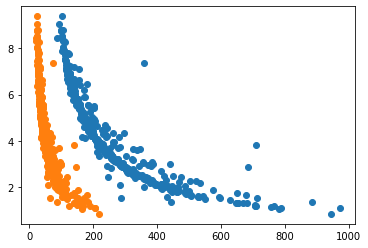

In [236]:
width = pd['width'].to_list()
dist = pd['dist'].to_list()
height = pd['height'].to_list()
plt.plot(width,dist,'o')
plt.plot(height,dist,'o')

plt.show()

[946.066162109375, 783.5224609375, 789.0452880859375, 973.7891845703124, 757.9720458984375, 708.1943359375, 765.9490966796875, 708.906494140625, 707.8460693359375, 668.7418212890625]
[0.85, 1.06, 1.09, 1.12, 1.16, 1.19, 1.2, 1.2, 1.25, 1.32]


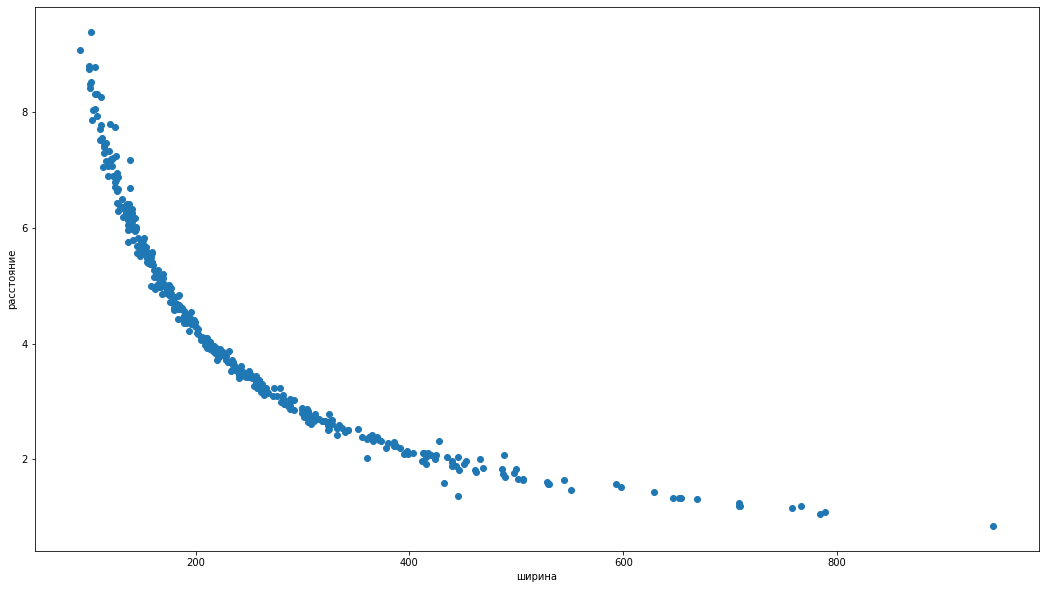

442 442


In [237]:
#чистим один параметр. длиную сторону рамки
width = pd['width'].to_list()
dist = pd['dist'].to_list()
print(width[:10])
print(dist[:10])
ind = []
step = 50
for i in range(len(width)-step):
    lit = width[i:i+step] 
    
    q1 = np.quantile(lit, 0.25 )
    q3 = np.quantile(lit, 0.75 )
    med = np.median(lit)
    iqr = q3 - q1
    upper_bound = q3 + ( 1.5 * iqr)
    lower_bound = q1 - ( 1.5 * iqr)
    for j in range(i,i+step):
        if (width[j] >upper_bound) or (width[j] < lower_bound):
            ind.append(j)
            #print(j, width[j], dist[j])
            
ind = list(set(ind))
ind.sort()         
ind.reverse()
for i in ind:
    width.pop(i)
    dist.pop(i)
fig, ax = plt.subplots(figsize = (18,10))
ax.scatter(width, dist)
 
# x-axis label
ax.set_xlabel('ширина')
 
# y-axis label
ax.set_ylabel('расстояние')
plt.show()
print(len(width), len(dist))

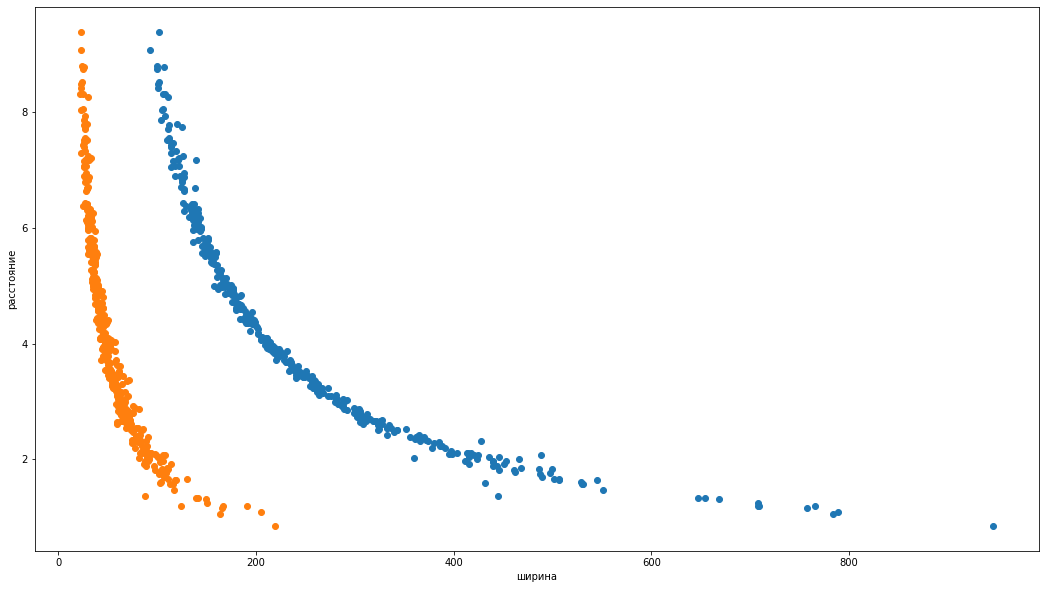

430 430


In [243]:
#чистим сразу два параметре
width = pd['width'].to_list()
dist = pd['dist'].to_list()
height = pd['height'].to_list()
ind = []
step = 50
for i in range(len(dist)-step):
    lit = width[i:i+step] 
    
    q1 = np.quantile(lit, 0.25 )
    q3 = np.quantile(lit, 0.75 )
    med = np.median(lit)
    iqr = q3 - q1
    upper_bound = q3 + ( 1.5 * iqr)
    lower_bound = q1 - ( 1.5 * iqr)
    for j in range(i,i+step):
        if (width[j] >upper_bound) or (width[j] < lower_bound):
            ind.append(j)
            #print(j, width[j], dist[j])
for i in range(len(dist)-step):
    lit = height[i:i+step] 
    
    q1 = np.quantile(lit, 0.25 )
    q3 = np.quantile(lit, 0.75 )
    med = np.median(lit)
    iqr = q3 - q1
    upper_bound = q3 + ( 1.5 * iqr)
    lower_bound = q1 - ( 1.5 * iqr)
    for j in range(i,i+step):
        if (height[j] >upper_bound) or (height[j] < lower_bound):
            ind.append(j)
            
            
            
ind = list(set(ind))
ind.sort()         
ind.reverse()
for i in ind:
    width.pop(i)
    dist.pop(i)
    height.pop(i)
fig, ax = plt.subplots(figsize = (18,10))
ax.scatter(width, dist)
ax.scatter(height, dist)
 
# x-axis label
ax.set_xlabel('ширина')
 
# y-axis label
ax.set_ylabel('расстояние')
plt.show()
print(len(width), len(dist))

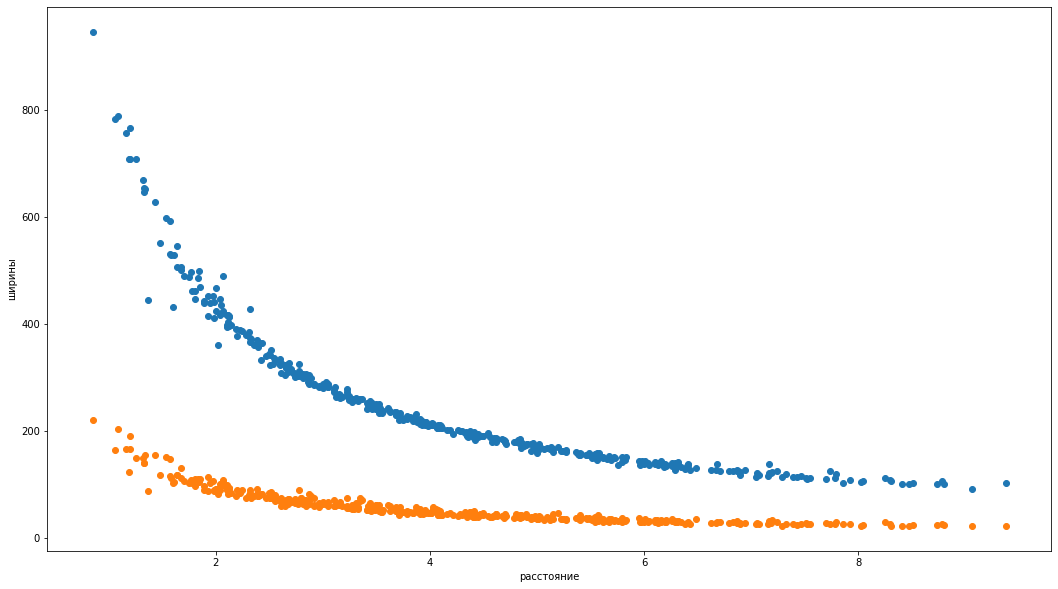

In [242]:
fig, ax = plt.subplots(figsize = (18,10))
ax.scatter(dist,width)
ax.scatter(dist,height)
 
# x-axis label
ax.set_xlabel('расстояние')
 
# y-axis label
ax.set_ylabel('ширины')
plt.show()

In [112]:
koef = np.polyfit(np.array(x),np.array(y),  2)
https://pythonpip.ru/examples/podgonka-krivoy-v-python-s-pomoschyu-biblioteki-scipy

In [244]:
def mnkGP(x,y): # функция которую можно использзовать в програме
    n=len(x) # количество элементов в списках
    s=sum(y) # сумма значений y
    s1=sum([1/x[i] for i in  range(0,n)]) #  сумма 1/x
    s2=sum([(1/x[i])**2 for i in  range(0,n)]) #  сумма (1/x)**2
    s3=sum([y[i]/x[i]  for i in range(0,n)])  # сумма y/x                   
    a= round((s*s2-s1*s3)/(n*s2-s1**2),3) # коэфициент а с тремя дробными цифрами
    b=round((n*s3-s1*s)/(n*s2-s1**2),3)# коэфициент b с тремя дробными цифрами
    s4=[a+b/x[i] for i in range(0,n)] # список значений гиперболической функции              
    so=round(sum([abs(y[i] -s4[i]) for i in range(0,n)])/(n*sum(y))*100,3)   # средняя ошибка аппроксимации
    plt.title('Аппроксимация гиперболой Y='+str(a)+'+'+str(b)+'/x\n Средняя ошибка--'+str(so)+'%',size=14)
    plt.xlabel('Координата X', size=14)
    plt.ylabel('Координата Y', size=14)
    plt.plot(x, y, color='r', linestyle=' ', marker='o', label='Data(x,y)')
    plt.plot(x, s4, color='g', linewidth=2, label='Data(x,f(x)=a+b/x')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

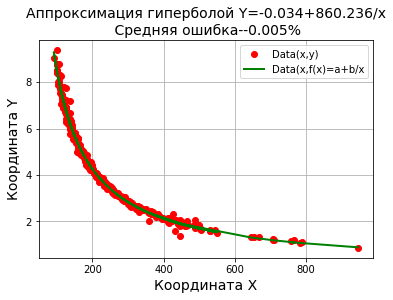

In [245]:
mnkGP(width,dist)

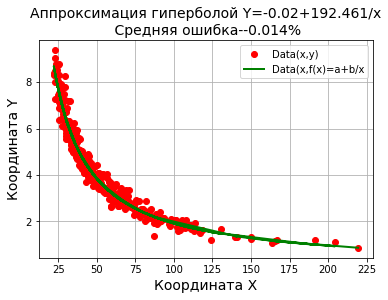

In [247]:
mnkGP(height,dist)

# ВАРИАНТ 1. ПО ФОРМУЛЕ. 

In [33]:
import pillow_heif
def conv_heic_to_jpg(file, new_name):

    heif_file = pillow_heif.read_heif(file)
    image = Image.frombytes(
        heif_file.mode,
        heif_file.size,
        heif_file.data,
        "raw",
    )
    
    #new_name = 'Y:\\temp.jpg' #так просто мы меняем расширение
    
    image.save(new_name, format("jpeg"))
    image.close()
    return new_name

In [15]:
keys = ['width', 'height', 's2', 'xmin', 'ymin', 'xmax', 'ymax', 'main_line', 'im_width', 'im_height']
pic_data = '..\\avto\\start_dataset\\test'
train_csv = '..\\avto\\start_dataset\\my_train.csv'
test = '..\\avto\\start_dataset\\sample_solution.csv'

temp_path = 'Y:'

new_f = 'image_name;distance'
#print(new_f)
not_recognize = []
for f in os.listdir(pic_data):
    work_file = os.path.join(pic_data, f)
    print('работаем  с файлом: ',work_file)
    #ОРИГИНАЛЬНЫЙ ФАЙЛ ТРОГАТ НЕЛЬЗЯ. ИНАЧЕ СОТРЕТСЯ EXIF
    temp_file = os.path.join(temp_path, f)
   
    img = Image.open(work_file)
    img = exif_transpose(img)
    img.save(temp_file)
    
    if '.heic' in f:
        conv_heic_to_jpg(temp_file)
    
    
    znak = res(temp_file)
    
    if len(znak) == 3:
        print('ФАЙЛ НЕ РАСПОЗНАН')
        not_recognize.append(f)
        continue
    #формируем строку с параметрами знака для записи в csv
    
    d1 = 860.236 / znak['width'] - 0.034
    d2 = 122.461 / znak['height']  - 0.02
    
    itog = (d1+d2)/2
    st = f+';' + str(itog)
        
    new_f = new_f +'\n'+st
    
#print(new_f)
with open(test, 'w', encoding = 'utf-8') as file:
    file.write(new_f)
print('не распознано файлов', len(not_recognize))
print('не распознанные', *not_recognize)

работаем  с файлом:  ..\avto\start_dataset\test\img_1597.jpg
работаем  с файлом:  ..\avto\start_dataset\test\img_1598.jpg
работаем  с файлом:  ..\avto\start_dataset\test\img_1599.jpg
работаем  с файлом:  ..\avto\start_dataset\test\img_1602.jpg
работаем  с файлом:  ..\avto\start_dataset\test\img_1604.jpg
работаем  с файлом:  ..\avto\start_dataset\test\img_1609.jpg
работаем  с файлом:  ..\avto\start_dataset\test\img_1610.jpg
работаем  с файлом:  ..\avto\start_dataset\test\img_1611.jpg
работаем  с файлом:  ..\avto\start_dataset\test\img_1617.jpg
работаем  с файлом:  ..\avto\start_dataset\test\img_1622.jpg
работаем  с файлом:  ..\avto\start_dataset\test\img_1625.jpg
работаем  с файлом:  ..\avto\start_dataset\test\img_1629.jpg
работаем  с файлом:  ..\avto\start_dataset\test\img_1630.jpg
работаем  с файлом:  ..\avto\start_dataset\test\img_1632.jpg
работаем  с файлом:  ..\avto\start_dataset\test\img_1633.jpg
работаем  с файлом:  ..\avto\start_dataset\test\img_1636.jpg
работаем  с файлом:  ..\

работаем  с файлом:  ..\avto\start_dataset\test\img_1974.jpg
работаем  с файлом:  ..\avto\start_dataset\test\img_1975.jpg
работаем  с файлом:  ..\avto\start_dataset\test\img_1978.jpg
работаем  с файлом:  ..\avto\start_dataset\test\img_1981.jpg
работаем  с файлом:  ..\avto\start_dataset\test\img_1982.jpg
работаем  с файлом:  ..\avto\start_dataset\test\img_1986.jpg
работаем  с файлом:  ..\avto\start_dataset\test\img_1987.jpg
работаем  с файлом:  ..\avto\start_dataset\test\img_1988.jpg
работаем  с файлом:  ..\avto\start_dataset\test\img_1989.jpg
работаем  с файлом:  ..\avto\start_dataset\test\img_1990.jpg
работаем  с файлом:  ..\avto\start_dataset\test\img_1993.jpg
работаем  с файлом:  ..\avto\start_dataset\test\img_1995.jpg
работаем  с файлом:  ..\avto\start_dataset\test\img_1997.jpg
работаем  с файлом:  ..\avto\start_dataset\test\img_1998.jpg
работаем  с файлом:  ..\avto\start_dataset\test\img_1999.jpg
работаем  с файлом:  ..\avto\start_dataset\test\img_2004.jpg
работаем  с файлом:  ..\

работаем  с файлом:  ..\avto\start_dataset\test\img_2464.jpg
работаем  с файлом:  ..\avto\start_dataset\test\img_2465.jpg
работаем  с файлом:  ..\avto\start_dataset\test\img_2466.jpg
работаем  с файлом:  ..\avto\start_dataset\test\img_2467.jpg
работаем  с файлом:  ..\avto\start_dataset\test\img_2471.jpg
работаем  с файлом:  ..\avto\start_dataset\test\img_2472.jpg
работаем  с файлом:  ..\avto\start_dataset\test\img_2473.jpg
работаем  с файлом:  ..\avto\start_dataset\test\img_2475.jpg
работаем  с файлом:  ..\avto\start_dataset\test\img_2478.jpg
работаем  с файлом:  ..\avto\start_dataset\test\img_2479.jpg
работаем  с файлом:  ..\avto\start_dataset\test\img_2481.jpg
работаем  с файлом:  ..\avto\start_dataset\test\img_2482.jpg
работаем  с файлом:  ..\avto\start_dataset\test\img_2483.jpg
работаем  с файлом:  ..\avto\start_dataset\test\img_2486.jpg
работаем  с файлом:  ..\avto\start_dataset\test\img_2488.jpg
работаем  с файлом:  ..\avto\start_dataset\test\img_2489.jpg
работаем  с файлом:  ..\

работаем  с файлом:  ..\avto\start_dataset\test\img_2698.jpg
работаем  с файлом:  ..\avto\start_dataset\test\img_2699.jpg
работаем  с файлом:  ..\avto\start_dataset\test\img_2700.jpg
работаем  с файлом:  ..\avto\start_dataset\test\img_2701.jpg
работаем  с файлом:  ..\avto\start_dataset\test\img_2702.heic
работаем  с файлом:  ..\avto\start_dataset\test\img_2702.jpg
работаем  с файлом:  ..\avto\start_dataset\test\img_2703.heic
работаем  с файлом:  ..\avto\start_dataset\test\img_2703.jpg
работаем  с файлом:  ..\avto\start_dataset\test\img_2704.heic
работаем  с файлом:  ..\avto\start_dataset\test\img_2706.heic
работаем  с файлом:  ..\avto\start_dataset\test\img_2707.heic
работаем  с файлом:  ..\avto\start_dataset\test\img_2708.heic
работаем  с файлом:  ..\avto\start_dataset\test\img_2710.jpg
работаем  с файлом:  ..\avto\start_dataset\test\img_2711.heic
работаем  с файлом:  ..\avto\start_dataset\test\img_2711.jpg
работаем  с файлом:  ..\avto\start_dataset\test\img_2712.heic
работаем  с файл

# Вариант 2. По фокусному расстоянию

In [15]:
from exif import Image as exif
def  get_focus_from_exif(f):
    with open(f, "rb") as palm_1_file:
        palm_1_image = exif(palm_1_file)
    if palm_1_image.has_exif:
        focal = palm_1_image.get('focal_length_in_35mm_film', 'Unknown')
    else:
        focal = 0
    
    return focal

In [8]:
pic_data = '..\\avto\\start_dataset\\test'
#выбираем все хейк файлы
focal_heic = dict()
for f in os.listdir(pic_data):
    if '.heic' in f:
        focal_heic[f] = ''
print(focal_heic)
        

{'img_2674.heic': '', 'img_2677.heic': '', 'img_2679.heic': '', 'img_2684.heic': '', 'img_2686.heic': '', 'img_2689.heic': '', 'img_2692.heic': '', 'img_2693.heic': '', 'img_2697.heic': '', 'img_2698.heic': '', 'img_2702.heic': '', 'img_2703.heic': '', 'img_2704.heic': '', 'img_2706.heic': '', 'img_2707.heic': '', 'img_2708.heic': '', 'img_2711.heic': '', 'img_2712.heic': '', 'img_2713.heic': '', 'img_2715.heic': '', 'img_2716.heic': '', 'img_2717.heic': '', 'img_2718.heic': '', 'img_2719.heic': '', 'img_2720.heic': '', 'img_2725.heic': '', 'img_2728.heic': '', 'img_2731.heic': '', 'img_2732.heic': '', 'img_2736.heic': '', 'img_2739.heic': '', 'img_2742.heic': '', 'img_2750.heic': '', 'img_2752.heic': '', 'img_2753.heic': '', 'img_2755.heic': ''}


In [ ]:
FOCAL_HEIC = {{'img_2674.heic': 14, 'img_2677.heic': 14, 'img_2679.heic': 14, 'img_2684.heic': 14, 'img_2686.heic': 14, 'img_2689.heic': 14, 'img_2692.heic': 14, 'img_2693.heic': 14, 'img_2697.heic': 14, 'img_2698.heic': 14, 'img_2702.heic': '', 'img_2703.heic': 14, 'img_2704.heic': 14, 'img_2706.heic': '', 'img_2707.heic': 14, 'img_2708.heic': 14, 'img_2711.heic': 14, 'img_2712.heic': 14, 'img_2713.heic': 14, 'img_2715.heic': 14, 'img_2716.heic': 14, 'img_2717.heic': 14, 'img_2718.heic': 14, 'img_2719.heic': 14, 'img_2720.heic': 14, 'img_2725.heic': 14, 'img_2728.heic': 14, 'img_2731.heic': 14, 'img_2732.heic': 14, 'img_2736.heic': 14, 'img_2739.heic': 14, 'img_2742.heic': 14, 'img_2750.heic': 14, 'img_2752.heic': 14, 'img_2753.heic': 14, 'img_2755.heic': 14}}

In [80]:
def file_recognition(f):
    temp_path = 'Y:\\'
    w_znak = 520 #ширина знака в мм
    w = 4032    #разрешение матрицы/фото в пикселях
    w_matrix = 34.974 #ширина матрицы в мм
    pixel_in_mm = w/w_matrix
    name_file = f[f.rfind('\\')+1:]
    
    
    
    work_file = f
    temp_file = os.path.join(temp_path, name_file)
    
    
    if '.heic' in f:
        focus = 14 #Вообще есть словань, но там везде 14
        temp_file = temp_file.replace('.heic','.jpg')
        work_file = conv_heic_to_jpg(work_file,temp_file)
    else:
        focus = get_focus_from_exif(work_file)
     
    img = Image.open(work_file)
    img = exif_transpose(img)
    //print('сохранили поворот',temp_file)
    img.save(temp_file)
    img.close()


    
    znak = res(temp_file)
    
    if len(znak) == 3:
        print('ФАЙЛ НЕ РАСПОЗНАН', f)
        not_recognize.append(f)
        d = 0.0
    #формируем строку с параметрами знака для записи в csv
    else:
        d = (znak['width']/pixel_in_mm + w_znak)/(znak['width']/pixel_in_mm) * focus/1000
    
    return d

SyntaxError: invalid syntax (2751650073.py, line 24)

In [47]:
w_znak = 520 #ширина знака в мм
w = 4032    #разрешение матрицы/фото в пикселях
w_matrix = 34.974 #ширина матрицы в мм
pixel_in_mm = w/w_matrix

keys = ['width', 'height', 's2', 'xmin', 'ymin', 'xmax', 'ymax', 'main_line', 'im_width', 'im_height']
pic_data = '..\\avto\\start_dataset\\test'
train_csv = '..\\avto\\start_dataset\\my_train.csv'
test = '..\\avto\\start_dataset\\sample_solution.csv'
temp_path = 'Y:\\'


new_f = 'image_name;distance'
#print(new_f)
not_recognize = []
n = 0
for f in os.listdir(pic_data):
    n +=1
#     if n<= 380:
#         continue
    if n>5:
        break
    
    
    work_file = os.path.join(pic_data, f)
    print(n,'работаем  с файлом: ',work_file)

    itog = file_recognition(work_file)
    st = f+';' + str(itog)
    print('ВЫХОД',st)
        
    new_f = new_f +'\n'+st
    
#print(new_f)
with open(test, 'w', encoding = 'utf-8') as file:
    file.write(new_f)
print('не распознано файлов', len(not_recognize))
print('не распознанные', *not_recognize)

1 работаем  с файлом:  ..\avto\start_dataset\test\img_1597.jpg
ВЫХОД img_1597.jpg;3.7757822162062467
2 работаем  с файлом:  ..\avto\start_dataset\test\img_1598.jpg
ВЫХОД img_1598.jpg;2.5753331500908034
3 работаем  с файлом:  ..\avto\start_dataset\test\img_1599.jpg
ВЫХОД img_1599.jpg;1.9439855323896003
4 работаем  с файлом:  ..\avto\start_dataset\test\img_1602.jpg
ВЫХОД img_1602.jpg;2.6398135379495296
5 работаем  с файлом:  ..\avto\start_dataset\test\img_1604.jpg
ВЫХОД img_1604.jpg;1.5403497358839795
не распознано файлов 0
не распознанные


In [59]:
d = file_recognition('..\\avto\\start_dataset\\test\\img_2717.jpg')
print(d)

6
повернули
сохранили поворот Y:\img_2717.jpg
ФАЙЛ НЕ РАСПОЗНАН ..\avto\start_dataset\test\img_2717.jpg
0.0


In [63]:
img = Image.open('..\\avto\\start_dataset\\test\\img_2717.jpg')
img = img.rotate(-90, expand=True)
img.save('Y:\\img_2717.jpg')

In [15]:
from exif import Image as exif

In [ ]:
#не распознанные img_2674.heic img_2715.jpg img_2717.jpg

In [40]:
get_focus_from_exif("..\\avto\\start_dataset\\test\\img_1602.jpg")

17

In [29]:
with open("..\\avto\\start_dataset\\test\\img_1599.jpg", "rb") as palm_1_file:
    palm_1_image = exif(palm_1_file)
with open("..\\avto\\start_dataset\\test\\img_1602.jpg", "rb") as palm_2_file:
    palm_2_image = exif(palm_2_file)
images = [palm_1_image, palm_2_image]

In [24]:
if palm_1_image.has_exif:
    status = f"contains EXIF (version {palm_1_image.exif_version}) information."
else:
    status = "does not contain any EXIF information."
print(f"Image {status}")

Image contains EXIF (version 0232) information.


In [30]:
image_members = []

for image in images:
    image_members.append(dir(image))

for index, image_member_list in enumerate(image_members):
    print(f"Image {index} contains {len(image_member_list)} members:")
    print(f"{image_member_list}\n")

Image 0 contains 74 members:
['<unknown EXIF tag 316>', '<unknown EXIF tag 42080>', '_exif_ifd_pointer', '_gps_ifd_pointer', '_segments', 'aperture_value', 'brightness_value', 'color_space', 'components_configuration', 'compression', 'datetime', 'datetime_digitized', 'datetime_original', 'delete', 'delete_all', 'digital_zoom_ratio', 'exif_version', 'exposure_bias_value', 'exposure_mode', 'exposure_program', 'exposure_time', 'f_number', 'flash', 'flashpix_version', 'focal_length', 'focal_length_in_35mm_film', 'get', 'get_all', 'get_file', 'get_thumbnail', 'gps_altitude', 'gps_altitude_ref', 'gps_dest_bearing', 'gps_dest_bearing_ref', 'gps_horizontal_positioning_error', 'gps_img_direction', 'gps_img_direction_ref', 'gps_latitude', 'gps_latitude_ref', 'gps_longitude', 'gps_longitude_ref', 'gps_speed', 'gps_speed_ref', 'has_exif', 'jpeg_interchange_format', 'jpeg_interchange_format_length', 'lens_make', 'lens_model', 'lens_specification', 'list_all', 'make', 'maker_note', 'metering_mode', 

In [41]:
palm_1_image.get('focal_length_in_35mm_film', 'Unknown')

17

In [43]:
for i in image_member_list:
    print(i,palm_1_image.get(i, 'Unknown'))

<unknown EXIF tag 316> Unknown
<unknown EXIF tag 42080> Unknown
_exif_ifd_pointer 226
_gps_ifd_pointer 2192
_segments Unknown
aperture_value 2.5260688112781806
brightness_value 8.91151083143064
color_space ColorSpace.UNCALIBRATED
components_configuration Unknown
compression 6
datetime 2022:07:07 11:04:56
datetime_digitized 2022:07:07 11:04:56
datetime_original 2022:07:07 11:04:56
delete Unknown
delete_all Unknown
digital_zoom_ratio 1.261050875729775
exif_version 0232
exposure_bias_value 0.0
exposure_mode ExposureMode.AUTO_EXPOSURE
exposure_program ExposureProgram.NORMAL_PROGRAM
exposure_time 0.0027548209366391185
f_number 2.4
flash Flash(flash_fired=False, flash_return=FlashReturn.NO_STROBE_RETURN_DETECTION_FUNCTION, flash_mode=FlashMode.COMPULSORY_FLASH_SUPPRESSION, flash_function_not_present=False, red_eye_reduction_supported=False, reserved=0)
flashpix_version Unknown
focal_length 1.54
focal_length_in_35mm_film 17
get Unknown
get_all Unknown
get_file Unknown
get_thumbnail Unknown
gp

In [34]:
for index, image in enumerate(images):
    print(f"Lens and OS - Image {index}")
    print("---------------------")
    print(f"focal_length_in_35mm_film: {image.get('focal_length_in_35mm_film', 'Unknown')}")
    print(f"Lens model: {image.get('lens_model', 'Unknown')}")
    print(f"Lens specification: {image.get('lens_specification', 'Unknown')}")
    print(f"OS version: {image.get('software', 'Unknown')}\n")

Lens and OS - Image 0
---------------------
focal_length_in_35mm_film: 17
Lens model: iPhone 11 back dual wide camera 1.54mm f/2.4
Lens specification: (1.5399999618512084, 4.25, 1.8, 2.4)
OS version: 15.5

Lens and OS - Image 1
---------------------
focal_length_in_35mm_film: 17
Lens model: iPhone 11 back dual wide camera 1.54mm f/2.4
Lens specification: (1.5399999618512084, 4.25, 1.8, 2.4)
OS version: 15.5



In [31]:
for i in image_member_list:
    print(i)

<unknown EXIF tag 316>
<unknown EXIF tag 42080>
_exif_ifd_pointer
_gps_ifd_pointer
_segments
aperture_value
brightness_value
color_space
components_configuration
compression
datetime
datetime_digitized
datetime_original
delete
delete_all
digital_zoom_ratio
exif_version
exposure_bias_value
exposure_mode
exposure_program
exposure_time
f_number
flash
flashpix_version
focal_length
focal_length_in_35mm_film
get
get_all
get_file
get_thumbnail
gps_altitude
gps_altitude_ref
gps_dest_bearing
gps_dest_bearing_ref
gps_horizontal_positioning_error
gps_img_direction
gps_img_direction_ref
gps_latitude
gps_latitude_ref
gps_longitude
gps_longitude_ref
gps_speed
gps_speed_ref
has_exif
jpeg_interchange_format
jpeg_interchange_format_length
lens_make
lens_model
lens_specification
list_all
make
maker_note
metering_mode
model
offset_time
offset_time_digitized
offset_time_original
orientation
photographic_sensitivity
pixel_x_dimension
pixel_y_dimension
resolution_unit
scene_capture_type
scene_type
sensing_m

In [97]:
import exifread
f = open('..\\avto\\start_dataset\\test\\img_2674.heic', 'rb')
#f = open('..\\avto\\start_dataset\\test\\img_1598.jpg', 'rb')

tags = exifread.process_file(f,details=False)

NoParser: hdlr

In [96]:
tags['EXIF FocalLengthIn35mmFilm']

(0xA405) Short=17 @ 608

In [93]:
for tag in tags.keys():
    print ("Key: %s, value %s" % (tag, tags[tag]))

Key: Image Make, value Apple
Key: Image Model, value iPhone 11
Key: Image Orientation, value Horizontal (normal)
Key: Image XResolution, value 72
Key: Image YResolution, value 72
Key: Image ResolutionUnit, value Pixels/Inch
Key: Image Software, value 15.5
Key: Image DateTime, value 2022:07:07 11:04:10
Key: Image HostComputer, value iPhone 11
Key: Image YCbCrPositioning, value Centered
Key: Image ExifOffset, value 226
Key: GPS GPSLatitudeRef, value N
Key: GPS GPSLatitude, value [54, 19, 4599/100]
Key: GPS GPSLongitudeRef, value E
Key: GPS GPSLongitude, value [48, 23, 861/20]
Key: GPS GPSAltitudeRef, value 0
Key: GPS GPSAltitude, value 475297/2619
Key: GPS GPSSpeedRef, value K
Key: GPS GPSSpeed, value 0
Key: GPS GPSImgDirectionRef, value T
Key: GPS GPSImgDirection, value 390347/2216
Key: GPS GPSDestBearingRef, value T
Key: GPS GPSDestBearing, value 390347/2216
Key: GPS Tag 0x001F, value 54304/11167
Key: Image GPSInfo, value 2192
Key: Thumbnail Compression, value JPEG (old-style)
Key: Thu

In [73]:
decodeImage('..\avto\start_dataset\test\img_2674.heic')

NameError: name 'pyheif' is not defined

In [103]:
heif_file = pillow_heif.open_heif('..\\avto\\start_dataset\\test\\img_2674.heic')
print("image mode:", heif_file.mode)
print("image data length:", len(heif_file.data))
print("image data stride:", heif_file.stride)
heif_file.convert_to("RGB;16")  # convert 10 bit image to RGB 16 bit.
print("image mode:", heif_file.info.keys())

image mode: RGB
image data length: 36578304
image data stride: 12096
image mode: dict_keys(['exif', 'xmp', 'primary', 'metadata', 'icc_profile', 'icc_profile_type'])


In [108]:
print(heif_file.info['exif'])

b'Exif\x00\x00MM\x00*\x00\x00\x00\x08\x00\x0b\x01\x0f\x00\x02\x00\x00\x00\x06\x00\x00\x00\x92\x01\x10\x00\x02\x00\x00\x00\n\x00\x00\x00\x98\x01\x12\x00\x03\x00\x00\x00\x01\x00\x01\x00\x00\x01\x1a\x00\x05\x00\x00\x00\x01\x00\x00\x00\xa2\x01\x1b\x00\x05\x00\x00\x00\x01\x00\x00\x00\xaa\x01(\x00\x03\x00\x00\x00\x01\x00\x02\x00\x00\x011\x00\x02\x00\x00\x00\x07\x00\x00\x00\xb2\x012\x00\x02\x00\x00\x00\x14\x00\x00\x00\xba\x01<\x00\x02\x00\x00\x00\n\x00\x00\x00\xce\x87i\x00\x04\x00\x00\x00\x01\x00\x00\x00\xd8\x88%\x00\x04\x00\x00\x00\x01\x00\x00\t\x1a\x00\x00\x00\x00Apple\x00iPhone 12\x00\x00\x00\x00H\x00\x00\x00\x01\x00\x00\x00H\x00\x00\x00\x0115.4.1\x00\x002022:07:10 21:12:03\x00iPhone 12\x00\x00$\x82\x9a\x00\x05\x00\x00\x00\x01\x00\x00\x02\x8e\x82\x9d\x00\x05\x00\x00\x00\x01\x00\x00\x02\x96\x88"\x00\x03\x00\x00\x00\x01\x00\x02\x00\x00\x88\'\x00\x03\x00\x00\x00\x01\x03\xe8\x00\x00\x90\x00\x00\x07\x00\x00\x00\x040232\x90\x03\x00\x02\x00\x00\x00\x14\x00\x00\x02\x9e\x90\x04\x00\x02\x00\x00\x00\

In [ ]:
 heif_file = pillow_heif.read_heif(file)
    image = Image.frombytes(
        heif_file.mode,
        heif_file.size,
        heif_file.data,

In [ ]:
https://pillow-heif.readthedocs.io/en/latest/reference/API.html